## Initialize

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
import copy 
import seaborn as sn
import random
import pandas as pd
import seaborn as sns
import numpy as np

import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sklearn
from sklearn.metrics import confusion_matrix
sys.path.append('./third_party')
import pdb
from scipy.stats.mstats import mquantiles
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available? {}".format(torch.cuda.is_available()))

sys.path.append('./codes/')
from bbox import BlackBox
from split_conf import SplitConformal, evaluate_predictions, ProbAccum
from auxiliary import eval_predictions, KL, cvm
from data_gen import Model_Ex1, Oracle, difficulty_oracle

Is CUDA available? False


## Set the random seeds

In [2]:
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Sample the data

In [3]:
p = 100                                                # Number of features
K = 6                                                  # Number of possible labels
delta_1 = 0.0
delta_2 = 0.2
a = 0.5

data_model = Model_Ex1(K,p,delta_1, delta_2,a)           # Data generating model

n_train = 2000                                         # Number of data samples
X_train = data_model.sample_X(n_train)                 # Generate the data features
Y_train = data_model.sample_Y(X_train)                 # Generate the data labels conditional on the features

n_tr_score = int(n_train*0.2)                          # Number of data samples for training the new loss
X_tr_score = data_model.sample_X(n_tr_score)           # Generate the data features
Y_tr_score = data_model.sample_Y(X_tr_score)           # Generate the data labels conditional on the features

n_hout = 2000                                         # Number of data samples
X_hout = data_model.sample_X(n_hout)
Y_hout = data_model.sample_Y(X_hout)

n_calib = 10000                                        # Number of test samples
X_calib = data_model.sample_X(n_calib)                 # Generate independent test data
Y_calib = data_model.sample_Y(X_calib)

n_test = 2000                                          # Number of test samples
X_test = data_model.sample_X(n_test, test=True)                   # Generate independent test data
Y_test = data_model.sample_Y(X_test)

# Name prefix of output files
out_prefix = "model_ex1"

## Visualize the data distribution

In [ ]:
# Marginal distribution of Y
plt.hist(Y_test, bins=K)
plt.xlabel("Y")
plt.title("Distribution of Y labels in the test data")
plt.show()

In [ ]:
prob_true = data_model.compute_prob(X_test)

fig=plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
k = 0 # Which label to plot?
plt.hist(prob_true[:,k], bins=50, range=(0,1))
plt.title("True probabilities label " + str(k))
plt.subplot(1, 2, 2)
k = 3 # Which label to plot?
plt.hist(prob_true[:,k], bins=50, range=(0,1))
plt.title("True probabilities label " + str(k))
plt.tight_layout()
plt.show()

## Oracle diagnostics 

In [ ]:
# Confidence level for the oracle
alpha = 0.1
 
oracle = Oracle(data_model)

# Find hard-to-classify samples (those samples for which the oracle needs larger sets; 75% quantile)
sc_method = SplitConformal(bbox=oracle)
S_oracle = sc_method.predict(X_test, alpha=alpha)
size_oracle = np.array([len(S) for S in S_oracle])
easy_idx, hard_idx = difficulty_oracle(S_oracle)

# Plot the marginal distribution of oracle prediction set sizes
plt.hist(size_oracle)
plt.xlabel("Size of oracle prediction sets (alpha={:.2f})".format(alpha))
plt.show()

# Plot the label-conditional distribution of oracle prediction set sizes
fig=plt.figure(figsize=(20, 3))
for k in range(K):
  plt.subplot(1, K, 1+k)
  idx_k = np.where(Y_test==k)
  plt.hist(size_oracle[idx_k], bins=K+1)
  plt.xlim(0,K)
  plt.title("Y = {:d}".format(k))
plt.show()

In [ ]:
# Construct and evaluate conformal prediction sets based on the oracle
sc_method = SplitConformal()
sc_method.calibrate(X_calib, Y_calib, alpha, bbox=oracle)
sets = sc_method.predict(X_test)
res = evaluate_predictions(sets, X_test, Y_test, hard_idx, conditional=True)
res

In [ ]:
# Compute oracle conformity scores on test data
p_oracle_test = oracle.predict_proba(X_test)
grey_box = ProbAccum(p_oracle_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

# Plot the distribution of oracle conformity scores on test data
fig=plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(scores_test[easy_idx])
plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
plt.subplot(1, 2, 2)
plt.hist(scores_test[hard_idx])
plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))
plt.suptitle('Oracle. CVM: {:.2f}'.format(cvm(scores_test)))
plt.show()

# Train all models

In [ ]:
# Train model with CE loss

refit_model = True

num_features=X_train.shape[1]
num_classes = K
file_final = 'saved_model_orig_' + out_prefix

X_augmented = np.concatenate((X_train, X_tr_score),0)
Y_augmented = np.concatenate((Y_train, Y_tr_score),0)
        
if refit_model:
    box_ce = BlackBox(num_features, num_classes)
    stats_ce = box_ce.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=200, num_epochs=3000, lr=0.01, mu=0, optimizer='SGD',
                          save_model=True, save_checkpoint_period = 1,
                          name=file_final, early_stopping=True, 
                          name_CP='checkpoint_orig_'+out_prefix)
else:
    print('Loading model instead of training')
    box_ce = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_ce.model.load_state_dict(saved_stats['model_state'])
    stats_ce = saved_stats['stats']

In [10]:
# For early stopping loss
box_orig_ho_loss = BlackBox(num_features, num_classes)
saved_stats_ho_loss = torch.load('checkpoint_orig_'+out_prefix+'loss', map_location=device)
box_orig_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_orig_ho_acc = BlackBox(num_features, num_classes)
saved_stats_ho_acc = torch.load('checkpoint_orig_'+out_prefix+'acc', map_location=device)
box_orig_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

In [ ]:
# Train the new black box

refit_model = True
file_final = 'saved_model_new_' + out_prefix

Z_train = np.zeros(len(Y_train))
Z_tr_score = np.ones(len(Y_tr_score))
Z_augmented = np.concatenate((Z_train, Z_tr_score),0)


if refit_model:
    
    box_new = BlackBox(num_features, num_classes)
    stats_new = box_new.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout,
                                Z_train=Z_augmented,
                                batch_size=750, num_epochs=4000, lr=0.001,
                                mu=0.2, mu_size=0, alpha=0.1, 
                                save_model=True, save_checkpoint_period = 1,
                                name=file_final, early_stopping=True, 
                                name_CP='checkpoint_new_cs_'+out_prefix)

else:
    print('Loading model instead of training')
    box_new = BlackBox(num_features, num_classes, feature_augmentation=feature_augmentation)
    saved_stats = torch.load(file_final, map_location=device)
    box_new.model.load_state_dict(saved_stats['model_state'])
    stats_new = saved_stats['stats']

In [12]:
# For early stopping loss
box_new_ho_loss = BlackBox(num_features, num_classes)
saved_stats_new_loss = torch.load('checkpoint_new_cs_'+out_prefix+'loss')
box_new_ho_loss.model.load_state_dict(saved_stats_new_loss['model_state'])

# For early stopping acc
box_new_ho_acc = BlackBox(num_features, num_classes)
saved_stats_new_acc = torch.load('checkpoint_new_cs_'+out_prefix+'acc')
box_new_ho_acc.model.load_state_dict(saved_stats_new_acc['model_state'])

<All keys matched successfully>

In [ ]:
# Train the hybrid model

file_final = 'saved_model_hybrid_' + out_prefix
refit_model = True

if refit_model:
    box_hybrid = BlackBox(num_features, num_classes)
    stats_hybrid = box_hybrid.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout,
                                Z_train=Z_augmented,
                                batch_size=750, num_epochs=4000, lr=0.01,
                                mu=0, mu_size=0.2, alpha=0.1,  optimizer='SGD',
                                save_model=True, save_checkpoint_period = 1,
                                name=file_final, early_stopping=True, 
                                name_CP='checkpoint_hybrid_'+out_prefix, verbose=True)

else:
    print('Loading model instead of training')
    box_hybrid = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_hybrid.model.load_state_dict(saved_stats['model_state'])
    stats_hybrid = saved_stats['stats']

In [14]:
# For early stopping loss
box_hybrid_ho_loss = BlackBox(num_features, num_classes)
saved_stats_hybrid_loss = torch.load('checkpoint_hybrid_'+out_prefix+'loss')
box_hybrid_ho_loss.model.load_state_dict(saved_stats_hybrid_loss['model_state'])

# For early stopping acc
box_hybrid_ho_acc = BlackBox(num_features, num_classes)
saved_stats_hybrid_acc = torch.load('checkpoint_hybrid_'+out_prefix+'acc')
box_hybrid_ho_acc.model.load_state_dict(saved_stats_hybrid_acc['model_state'])

<All keys matched successfully>

In [ ]:
# Train model with focal loss
    
file_final = 'saved_model_FocalLoss_' + out_prefix
refit_model = True

if refit_model:
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1) # gamma 0 same as C.E.
    stats_fc = box_fc.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=200, mu=0, num_epochs=3000, lr=0.01, optimizer='SGD',
                          save_model=True, save_checkpoint_period = 1,
                          name=file_final, early_stopping=True, name_CP='checkpoint_FocalLoss_'+out_prefix, verbose=True) 

else:
    print('Loading model instead of training')
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=gamma)
    saved_stats = torch.load(file_final, map_location=device)
    box_fc.model.load_state_dict(saved_stats['model_state'])
    stats_fc = saved_stats['stats']

In [16]:
# For early stopping loss
box_focal_ho_loss = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_loss = torch.load('checkpoint_FocalLoss_'+out_prefix+'loss', map_location=device)
box_focal_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_focal_ho_acc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_acc = torch.load('checkpoint_FocalLoss_'+out_prefix+'acc', map_location=device)
box_focal_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

## Training diagnostics

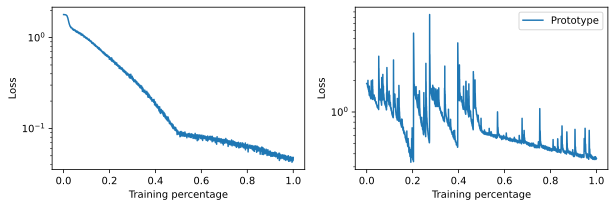

In [29]:
fig=plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["loss"], label="Cross-entropy")
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["loss"], label="Conformal")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.show()

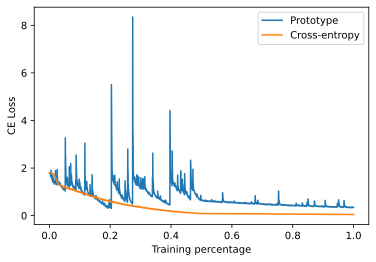

In [30]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["pred"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["pred"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("CE Loss")
#plt.yscale("log")
plt.show()

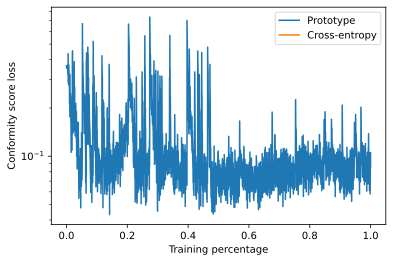

In [31]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["scores"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss")
plt.yscale("log")
plt.show()

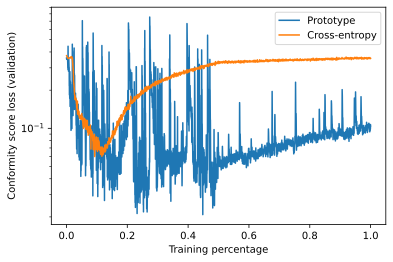

In [32]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["scores-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss (validation)")
plt.yscale('log')
plt.show()

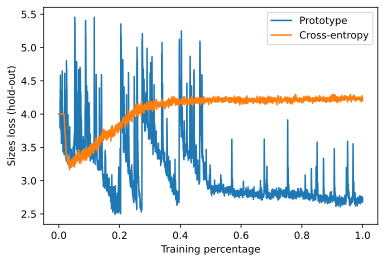

In [33]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["sizes-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["sizes-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Sizes loss (hold-out)")
plt.show()

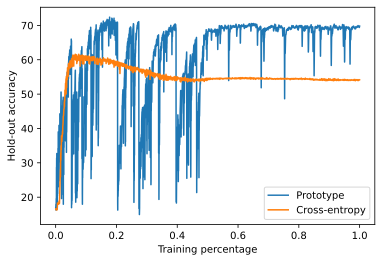

In [34]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["acc-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["acc-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Hold-out accuracy")
plt.show()

# Check results

## Predictive accuracy

In [ ]:
eval_predictions(X_test, Y_test, oracle, data="test (oracle)")
eval_predictions(X_test, Y_test, box_ce, data="test (CE)")
eval_predictions(X_test, Y_test, box_new, data="test (Conformal)")

In [ ]:
# Find hard-to-classify samples (those samples for which the oracle needs larger sets)
eval_predictions(X_test[hard_idx], Y_test[hard_idx], oracle, data="test (oracle, hard)")
eval_predictions(X_test[hard_idx], Y_test[hard_idx], box_ce, data="test (CE, hard)")
eval_predictions(X_test[hard_idx], Y_test[hard_idx], box_new, data="test (Conformal, hard)")

print("")
eval_predictions(X_test[easy_idx], Y_test[easy_idx], oracle, data="test (oracle, easy)")
eval_predictions(X_test[easy_idx], Y_test[easy_idx], box_ce, data="test (CE, easy)")
eval_predictions(X_test[easy_idx], Y_test[easy_idx], box_new, data="test (Conformal, easy)")
print("")

## Estimated conditional distribution

In [19]:
black_boxes = [oracle, box_ce, box_new, box_orig_ho_acc, box_new_ho_acc]
black_boxes_names = ["Oracle", "Cross-entropy", "Conformal",
                     "Cross-entropy ES acc", "Conformal ES acc"]

probs = [bbox.predict_proba(X_test) for bbox in black_boxes]

In [20]:
proba_new = box_new.predict_proba(X_test)

In [ ]:
plt.hist(np.max(proba_new,1))
plt.show()

In [ ]:
k_list = [0,1,5] # Which label to plot?

n_plots = len(probs)
fig=plt.figure(figsize=(len(k_list)*3, 25))
for i in range(n_plots):
  for j in range(len(k_list)):
    k = k_list[j]
    plt.subplot(n_plots*len(k_list), len(k_list), 1+i*len(k_list)+j)
    plt.hist(probs[i][:,k], bins=10, range=(0,1))
    plt.title(black_boxes_names[i])
plt.tight_layout()
plt.show()

In [ ]:
prob_true = data_model.compute_prob(X_test)
tmp_idx = np.asarray(np.where((prob_true[:,5] < 0.1) | (prob_true[:,5] > 0.9))).squeeze(0)
prd = box_new.predict_proba(X_test)
prd_1 = prd[tmp_idx,5]
fig = plt.figure()
plt.hist(prd_1, bins=10, range=(0,1))
plt.show()

## Conformity scores on test data

In [ ]:
#box = box_ce
box = box_new

# Form prediction sets on test data using CE model
print("Validation data")
p_hat_test = box.predict_proba(X_test)
grey_box = ProbAccum(p_hat_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)
alpha_hat_test = 1.0-mquantiles(1.0-scores_test,0.9)[0]
print("Alpha-hat: {:.3f}".format(alpha_hat_test))
sets_test = grey_box.predict_sets(alpha=alpha_hat_test, epsilon=epsilon_test)
size_test = np.mean(np.array([len(S) for S in sets_test]))
print("Length: {:.3f}".format(size_test))
coverage_test = np.mean(np.array([Y_test[i] in sets_test[i] for i in range(len(Y_test))]))
print("Coverage: {:.3f}".format(coverage_test))

# Form prediction sets on calibration data
print("\nTest data")
p_hat_test = box.predict_proba(X_hout)
grey_box = ProbAccum(p_hat_test)
epsilon_hout = np.random.uniform(size=(len(Y_hout,)))
scores_hout = grey_box.calibrate_scores(Y_hout, epsilon=epsilon_hout)
alpha_hat_hout = 1.0-mquantiles(1.0-scores_hout,0.9)[0]
print("Alpha-hat: {:.3f}".format(alpha_hat_hout))
sets_hout = grey_box.predict_sets(alpha=mquantiles(scores_hout,0.1)[0], epsilon=epsilon_hout)
size_hout = np.mean(np.array([len(S) for S in sets_hout]))
print("Length: {:.3f}".format(size_hout))
coverage_hout = np.mean(np.array([Y_hout[i] in sets_hout[i] for i in range(len(Y_hout))]))
print("Coverage: {:.3f}".format(coverage_hout))

In [ ]:
# Find hard-to-classify samples (those samples for which the oracle needs larger sets; 75% quantile)
sc_method = SplitConformal(bbox=oracle)
S_oracle = sc_method.predict(X_test, alpha=alpha)
easy_idx, hard_idx = difficulty_oracle(S_oracle)

# Form prediction sets on calibration data using CE model
p_hat_test = oracle.predict_proba(X_test)
grey_box = ProbAccum(p_hat_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

fig=plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.hist(scores_test[easy_idx])
plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
plt.subplot(1, 3, 2)
plt.hist(scores_test[hard_idx])
plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))
plt.subplot(1, 3, 3)
plt.hist(scores_test)
plt.title("All (n {:d}, CVM {:.2f})".format(len(scores_test), cvm(scores_test)))
plt.show()

In [ ]:
bbox_plot = box_ce      # choose bbox to plot histogram of scores

p_hat_test = box_ce.predict_proba(X_test)
grey_box = ProbAccum(p_hat_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

fig=plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.hist(scores_test[easy_idx])
plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
plt.subplot(1, 3, 2)
plt.hist(scores_test[hard_idx])
plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))
plt.subplot(1, 3, 3)
plt.hist(scores_test)
plt.title("All (n {:d}, CVM {:.2f})".format(len(scores_test), cvm(scores_test)))
plt.show()

In [ ]:
# Form prediction sets on calibration data using CE model
p_hat_test = box_ce.predict_proba(X_test)
grey_box = ProbAccum(p_hat_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test_ce = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

# Form prediction sets on calibration data with prototype
p_hat_test = box_new.predict_proba(X_test)
grey_box = ProbAccum(p_hat_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test_new = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

fig=plt.figure(figsize=(8, 20))
for k in range(K):
  scores_y_ce = scores_test_ce[Y_test==k]
  plt.subplot(K, 2, 2*k+1)
  plt.hist(scores_y_ce, bins=50)
  plt.title("Y = {:d} (n {:d}, CVM {:.2f})".format(k, len(scores_y_ce), cvm(scores_y_ce)))
  plt.subplot(K, 2, 2*k+2)
  scores_y_new = scores_test_new[Y_test==k]
  plt.hist(scores_y_new, bins=50)
  plt.title("Y = {:d} (n {:d}, CVM {:.2f})".format(k, len(scores_y_new), cvm(scores_y_new)))

plt.show()

## Split-conformal (evaluate)

In [28]:
black_boxes = [oracle, box_ce, box_orig_ho_loss, box_orig_ho_acc, 
                box_new, box_new_ho_loss, box_new_ho_acc,
                box_hybrid, box_hybrid_ho_loss, box_hybrid_ho_acc,
                box_fc, box_focal_ho_loss, box_focal_ho_acc]
black_boxes_names = ["Oracle", 
                       "Cross-entropy", "Cross-entropy ES loss", "Cross-entropy ES acc",
                       "Conformal", "Conformal ES loss", "Conformal ES acc",
                       "Hybrid", "Hybrid ES loss", "Hybrid ES acc",
                       "Focal", "Focal ES loss", "Focal ES acc"]


colors = ["amber", "red", "red", "red", "blue", "blue","blue", "black", "black", "black", "yellow", "yellow", "yellow"]

In [ ]:
alpha = 0.1

n_calib = 10000                                     # Number of calibration samples
X_calib = data_model.sample_X(n_calib)             # Generate independent calibration data
Y_calib = data_model.sample_Y(X_calib)

sc_methods = []
for i in range(len(black_boxes)):
  print("{:s}:".format(black_boxes_names[i]))
  sc_method = SplitConformal()
  sc_method.calibrate(X_calib, Y_calib, alpha, bbox=black_boxes[i])
  sc_methods.append(sc_method)

In [ ]:
results = pd.DataFrame()
results_full = pd.DataFrame()

from tqdm.notebook import tqdm

sc_method_oracle = SplitConformal(bbox=oracle)

for e in tqdm(range(10)):

  n_test = 2000                                          # Number of test samples
  X_test = data_model.sample_X(n_test)                   # Generate independent test data
  Y_test = data_model.sample_Y(X_test)

  S_oracle = sc_method_oracle.predict(X_test, alpha=alpha)
  size_oracle = np.array([len(S) for S in S_oracle])
  easy_idx, hard_idx = difficulty_oracle(S_oracle)

  for k in range(len(black_boxes)):
    sets = sc_methods[k].predict(X_test)
    res = evaluate_predictions(sets, X_test, Y_test, hard_idx, conditional=True)
  
    res['Model'] = black_boxes_names[k]
    res['Experiment'] = e

    sizes = [len(S) for S in sets]
    coverages = [Y_test[i] in sets[i] for i in range(len(Y_test))]
    res_full = pd.DataFrame({'Y':Y_test, 'Size':sizes, 'Coverage':coverages, 'Difficulty':size_oracle})
    res_full['Model'] = black_boxes_names[k]
    res_full['Experiment'] = e
  
    results = pd.concat([results, res])
    results_full = pd.concat([results_full, res_full])

In [ ]:
results.groupby(['Model']).mean()

In [ ]:
sn.reset_orig()
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Conditional coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size (median)')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()

In [ ]:
df = results_full.groupby(['Experiment', 'Model', 'Difficulty']).mean().reset_index()

g = sns.catplot(data = df, x = 'Model', y = 'Coverage', col='Difficulty', kind="box")
g.fig.set_size_inches(10,2)
g.set_xticklabels(rotation=90)
plt.show()

g = sns.catplot(data = df, x = 'Model', y = 'Size', col='Difficulty', kind="box")
g.fig.set_size_inches(10,2)
g.set_xticklabels(rotation=90)
plt.show()

In [ ]:
df = results_full.groupby(['Experiment', 'Model', 'Y']).mean().reset_index()

g = sns.catplot(data = df, x = 'Model', y = 'Coverage', col='Y', kind="box")
g.fig.set_size_inches(10,2)
g.set_xticklabels(rotation=90)
plt.show()

g = sns.catplot(data = df, x = 'Model', y = 'Size', col='Y', kind="box")
g.fig.set_size_inches(10,2)
g.set_xticklabels(rotation=90)
plt.show()

## Estimate conditional coverage (without oracle)

In [ ]:
black_boxes = [box_ce, box_new]
black_boxes_names = ["Cross-entropy", "Conformal"]

alpha = 0.1

n_calib = 10000                                     # Number of calibration samples
X_calib = data_model.sample_X(n_calib)             # Generate independent calibration data
Y_calib = data_model.sample_Y(X_calib)

sc_methods = []
cc_boxes = []
for i in range(len(black_boxes)):
  print("{:s}:".format(black_boxes_names[i]))
  # Calibrate the conformal prediction sets
  sc_method = SplitConformal()
  sc_method.calibrate(X_calib, Y_calib, alpha, bbox=black_boxes[i])
  sc_methods.append(sc_method)
  # Compute conformal prediction sets
  sets_calib = sc_method.predict(X_calib)
  sets_test = sc_method.predict(X_test)
  correct_calib = 1*np.array([Y_calib[i] in sets_calib[i] for i in range(len(Y_calib))])
  correct_test = 1*np.array([Y_test[i] in sets_test[i] for i in range(len(Y_test))])
  # Train the black box to recognize incorrectly classified samples
  box_cc = BlackBox(num_features, 2, family = "classification")
  stats_cc = box_cc.fit(X_calib, correct_calib,
                        X_hout=X_test, Y_hout=correct_test, 
                        batch_size=500, num_epochs=100, lr=0.001,
                        save_model = False
                        ) 
  cc_boxes.append(box_cc)

In [ ]:
results = pd.DataFrame()
results_full = pd.DataFrame()

from tqdm.notebook import tqdm

sc_method_oracle = SplitConformal(bbox=oracle)

for e in tqdm(range(10)):

  n_test = 2000                                          # Number of test samples
  X_test = data_model.sample_X(n_test)                   # Generate independent test data
  Y_test = data_model.sample_Y(X_test)

  for k in range(len(black_boxes)):
    sets = sc_methods[k].predict(X_test)

    proba_correct_test = cc_boxes[k].predict_proba(X_test)[:,1]
    idx_hard = np.where(proba_correct_test<0.5)[0]

    res = evaluate_predictions(sets, X_test, Y_test, idx_hard, conditional=True)
  
    res['Model'] = black_boxes_names[k]
    res['Experiment'] = e

    sizes = [len(S) for S in sets]
    coverages = [Y_test[i] in sets[i] for i in range(len(Y_test))]
    res_full = pd.DataFrame({'Y':Y_test, 'Size':sizes, 'Coverage':coverages, 'Difficulty':size_oracle})
    res_full['Model'] = black_boxes_names[k]
    res_full['Experiment'] = e
  
    results = pd.concat([results, res])
    results_full = pd.concat([results_full, res_full])

In [ ]:
sn.reset_orig()
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Conditional coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()